In [1]:
import matplotlib.pyplot as plot
import pandas as pd
import pandas.io.json as pj
import psycopg2
import os

In [6]:
conn = psycopg2.connect(os.environ.get('PROMSQL_CONNSTR').replace('/prometheus', '/apextoaster_stable'))
samples = pd.read_sql_query("""
SELECT 
    time, 
    value, 
    REGEXP_REPLACE(labels->>'instance', '\d+\.\d+\.\d+\.', 'xxx.yyy.zzz.') AS instance
FROM metrics 
WHERE name = 'node_load1' 
ORDER BY time DESC 
LIMIT 5000""", conn)
conn.close()

In [7]:
print(samples.head(5))

                     time  value              instance
0 2019-12-22 22:34:14.771   0.34  xxx.yyy.zzz.236:9100
1 2019-12-22 22:34:13.440   1.62  xxx.yyy.zzz.163:9100
2 2019-12-22 22:34:12.634   0.93  xxx.yyy.zzz.192:9100
3 2019-12-22 22:34:08.682   0.79   xxx.yyy.zzz.77:9100
4 2019-12-22 22:34:07.960   0.47  xxx.yyy.zzz.180:9100


In [10]:
nodes = samples[['instance']].replace(r':\d+', '', regex=True)
load = (samples.drop(columns=['instance']).join(nodes))

In [11]:
print(load.head(5))

                     time  value         instance
0 2019-12-22 22:34:14.771   0.34  xxx.yyy.zzz.236
1 2019-12-22 22:34:13.440   1.62  xxx.yyy.zzz.163
2 2019-12-22 22:34:12.634   0.93  xxx.yyy.zzz.192
3 2019-12-22 22:34:08.682   0.79   xxx.yyy.zzz.77
4 2019-12-22 22:34:07.960   0.47  xxx.yyy.zzz.180


In [12]:
iload = load.groupby(['instance'])
print(iload.describe())

                 value                                                       
                 count      mean       std   min     25%    50%     75%   max
instance                                                                     
xxx.yyy.zzz.158  555.0  0.195820  0.185309  0.00  0.0700  0.140  0.2600  1.24
xxx.yyy.zzz.163  556.0  1.165036  0.545385  0.22  0.7775  1.055  1.4825  3.85
xxx.yyy.zzz.164  555.0  0.324775  0.266025  0.00  0.1300  0.250  0.4350  1.72
xxx.yyy.zzz.180  556.0  0.528795  0.501916  0.02  0.2200  0.370  0.6600  4.75
xxx.yyy.zzz.192  556.0  0.475845  0.354291  0.03  0.2000  0.375  0.6800  1.86
xxx.yyy.zzz.236  556.0  0.265198  0.188345  0.00  0.1300  0.220  0.3325  1.24
xxx.yyy.zzz.59   555.0  0.567514  0.576339  0.06  0.3100  0.450  0.6200  5.36
xxx.yyy.zzz.77   556.0  0.476151  0.316315  0.02  0.2500  0.410  0.6100  2.29
xxx.yyy.zzz.99   555.0  0.402252  0.294127  0.02  0.2000  0.330  0.5400  2.12


In [13]:
tload = pd.pivot(load, index='time', columns='instance', values='value').resample('1min').max()
print(tload.head(2))

instance             xxx.yyy.zzz.158  xxx.yyy.zzz.163  xxx.yyy.zzz.164  \
time                                                                     
2019-12-22 17:56:00              0.0             0.66             0.96   
2019-12-22 17:57:00              0.0             0.56             1.20   

instance             xxx.yyy.zzz.180  xxx.yyy.zzz.192  xxx.yyy.zzz.236  \
time                                                                     
2019-12-22 17:56:00             1.21             0.14             0.91   
2019-12-22 17:57:00             0.99             0.13             1.07   

instance             xxx.yyy.zzz.59  xxx.yyy.zzz.77  xxx.yyy.zzz.99  
time                                                                 
2019-12-22 17:56:00            0.32            0.47             NaN  
2019-12-22 17:57:00            0.27            0.28             0.3  


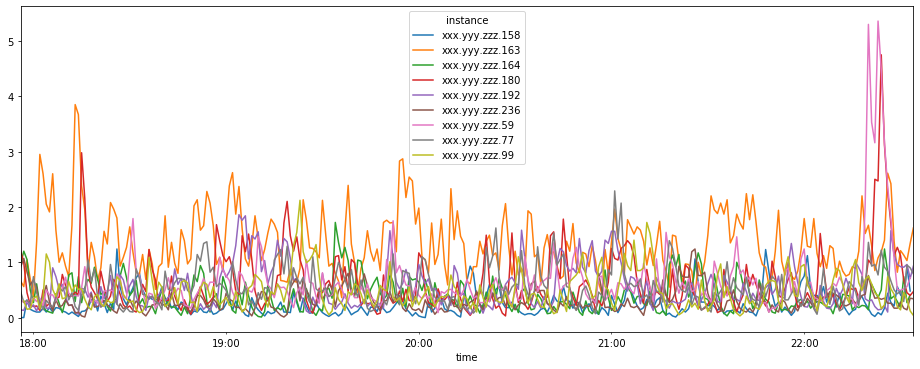

In [19]:
%matplotlib inline
tload.plot.line(
    linestyle='solid', 
    # dashes=[3.0, 1.0, 2.0, 1.0],
    subplots=False, 
    figsize=(16, 6)
)